In [3]:
# Step 1: Install libraries
!pip install -q segmentation-models-pytorch==0.3.3 torch torchvision albumentations==1.3.0 kaggle opencv-python matplotlib scikit-learn

In [4]:
# Step 2: Setup Kaggle and download dataset

import os

# Set uploaded kaggle.json path
kaggle_json_path = "/content/kaggle.json"

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.system(f"cp {kaggle_json_path} ~/.kaggle/")
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 600)

# Download and unzip dataset
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation
License(s): other
 79% 136M/172M [00:00<00:00, 409MB/s] 
100% 172M/172M [00:00<00:00, 428MB/s]


In [5]:
# Step 3: Import required libraries and define paths
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import numpy as np
import cv2
import os
import time
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset paths
BASE_DIR = "/content/ForestSegmented/ForestSegmented/"
IMG_DIR = os.path.join(BASE_DIR, "images")
MASK_DIR = os.path.join(BASE_DIR, "masks")

print("Total images:", len(os.listdir(IMG_DIR)))
print("Total masks:", len(os.listdir(MASK_DIR)))

Total images: 5108
Total masks: 5108


In [6]:
# Step 4: Split into train, val, test sets (80/10/10)
from sklearn.model_selection import train_test_split
import os, glob

# Directories
IMG_DIR = "/content/ForestSegmented/ForestSegmented/images/"
MASK_DIR = "/content/ForestSegmented/ForestSegmented/masks/"

# Get image paths
image_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))

# Define function to pair masks correctly
def pair_masks(image_list):
    masks = []
    for img in image_list:
        fname = os.path.basename(img)
        mask_name = fname.replace("_sat_", "_mask_")
        mask_path = os.path.join(MASK_DIR, mask_name)
        if os.path.exists(mask_path):
            masks.append(mask_path)
        else:
            print("Missing mask for:", fname)
    return masks

# Split dataset
train_imgs, temp_imgs = train_test_split(image_paths, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

# Get corresponding masks
train_masks = pair_masks(train_imgs)
val_masks = pair_masks(val_imgs)
test_masks = pair_masks(test_imgs)

In [7]:
# Step 5: Define Dataset class (with preprocessing and augmentation)
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from albumentations import Compose, Resize, Normalize, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 128

# --- Augmentations ---
train_transform = Compose([
    Resize(IMG_SIZE, IMG_SIZE),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

val_transform = Compose([
    Resize(IMG_SIZE, IMG_SIZE),
    Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])


# --- Custom Dataset ---
class ForestDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.imgs = img_paths
        self.masks = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]

        # Read image & mask
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"❌ Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"❌ Mask not found: {mask_path}")

        # Convert mask to binary (0 or 1)
        mask = (mask > 127).astype(np.float32)

        # Apply augmentation & preprocessing
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)  # [1, H, W] for BCE loss compatibility

        return img, mask


# --- Create Datasets ---
train_ds = ForestDataset(train_imgs, train_masks, transform=train_transform)
val_ds   = ForestDataset(val_imgs, val_masks, transform=val_transform)
test_ds  = ForestDataset(test_imgs, test_masks, transform=val_transform)

# --- DataLoaders ---
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2)

print("Dataloaders ready.")
print(f"Train batches: {len(train_dl)}, Val batches: {len(val_dl)}, Test batches: {len(test_dl)}")


Dataloaders ready.
Train batches: 511, Val batches: 64, Test batches: 64


In [8]:
# Step 6: Create model using segmentation_models_pytorch
import segmentation_models_pytorch as smp
import torch

def build_model(pretrained=True):
    # Use ResNet50 encoder for U-Net
    encoder_weights = "imagenet" if pretrained else None
    model = smp.Unet(
        encoder_name="resnet50",     # Encoder backbone
        encoder_weights=encoder_weights,  # Use pretrained encoder
        in_channels=3,               # RGB images
        classes=1,                   # Binary segmentation
        activation=None              # We'll apply sigmoid in loss
    )
    return model

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 301MB/s]


In [9]:
# Step 7: Define loss (BCE + Dice) and metrics
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return 1 - ((2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth))

bce = nn.BCEWithLogitsLoss()

def bce_dice_loss(pred, target):
    return bce(pred, target) + dice_loss(pred, target)

def iou_score(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred) > threshold
    target = target > 0.5
    intersection = (pred & target).sum().float()
    union = (pred | target).sum().float()
    return (intersection + 1e-6) / (union + 1e-6)

In [10]:
# Step 8: Define training and evaluation loops
import torch

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(imgs)  # raw logits
        preds = torch.sigmoid(preds)  # apply sigmoid for binary output

        loss = bce_dice_loss(preds, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_iou, total_loss = 0.0, 0.0

    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        preds = torch.sigmoid(preds)  # sigmoid for binary prediction

        loss = bce_dice_loss(preds, masks)
        total_loss += loss.item()

        total_iou += iou_score(preds, masks).item()

    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    return avg_loss, avg_iou


##Experiment 1: Training from Scratch

In [11]:
# Step 9: Train model from scratch (updated and safe version)
import time
import torch.optim as optim

model_scratch = build_model(pretrained=False).to(device)
optimizer = optim.Adam(model_scratch.parameters(), lr=1e-4)

epochs = 100
best_iou = 0.0
start_time = time.time()

print("Starting training from scratch...\n")

for epoch in range(1, epochs + 1):
    # Training phase
    train_loss = train_one_epoch(model_scratch, train_dl, optimizer)

    # Validation phase
    val_loss, val_iou = evaluate(model_scratch, val_dl)

    # Save best model checkpoint
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model_scratch.state_dict(), "unet_scratch_best.pth")
        print(f"Saved new best model at epoch {epoch} (IoU: {val_iou:.4f})")

    # Periodic logging
    if epoch % 5 == 0 or epoch == 1:
        print(f"[Epoch {epoch:03d}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val IoU: {val_iou:.4f}")

elapsed = time.time() - start_time
print(f"\n Finished training from scratch in {elapsed/60:.2f} minutes.")
print(f"Best Validation IoU: {best_iou:.4f}")

Starting training from scratch...

Saved new best model at epoch 1 (IoU: 0.6167)
[Epoch 001/100] Train Loss: 0.9490 | Val Loss: 0.9184 | Val IoU: 0.6167
Saved new best model at epoch 3 (IoU: 0.6207)
[Epoch 005/100] Train Loss: 0.8923 | Val Loss: 0.8839 | Val IoU: 0.6155
Saved new best model at epoch 7 (IoU: 0.6324)
Saved new best model at epoch 8 (IoU: 0.6767)
Saved new best model at epoch 10 (IoU: 0.6861)
[Epoch 010/100] Train Loss: 0.8822 | Val Loss: 0.8734 | Val IoU: 0.6861
[Epoch 015/100] Train Loss: 0.8777 | Val Loss: 0.8736 | Val IoU: 0.6618
[Epoch 020/100] Train Loss: 0.8745 | Val Loss: 0.9206 | Val IoU: 0.6771
Saved new best model at epoch 22 (IoU: 0.7198)
[Epoch 025/100] Train Loss: 0.8710 | Val Loss: 0.8703 | Val IoU: 0.6722
[Epoch 030/100] Train Loss: 0.8710 | Val Loss: 0.8713 | Val IoU: 0.6425
[Epoch 035/100] Train Loss: 0.8672 | Val Loss: 0.9126 | Val IoU: 0.6677
Saved new best model at epoch 36 (IoU: 0.7208)
[Epoch 040/100] Train Loss: 0.8648 | Val Loss: 0.8658 | Val IoU:

##Experiment 2: Transfer Learning (Frozen + Fine-tune)

In [12]:
# Step 10: Transfer Learning experiment
model_tl = build_model(pretrained=True).to(device)

# Phase 1: Freeze encoder
for param in model_tl.encoder.parameters():
    param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_tl.parameters()), lr=1e-4)

best_iou = 0
start = time.time()

# Phase 1 — 50 epochs (frozen)
for epoch in range(1, 51):
    train_loss = train_one_epoch(model_tl, train_dl, optimizer)
    val_loss, val_iou = evaluate(model_tl, val_dl)
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model_tl.state_dict(), "unet_tl_phase1_best.pth")
    if epoch % 10 == 0 or epoch == 1:
        print(f"[TL-Frozen] Epoch {epoch}/50 - Val IoU: {val_iou:.4f}")

# Phase 2 — Unfreeze all and fine-tune for 50 more
for param in model_tl.encoder.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_tl.parameters(), lr=1e-5)

for epoch in range(51, 101):
    train_loss = train_one_epoch(model_tl, train_dl, optimizer)
    val_loss, val_iou = evaluate(model_tl, val_dl)
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model_tl.state_dict(), "unet_tl_best.pth")
    if epoch % 10 == 0 or epoch == 51:
        print(f"[TL-Finetune] Epoch {epoch}/100 - Val IoU: {val_iou:.4f}")

time_tl = time.time() - start
print(f"Finished transfer learning in {time_tl/60:.2f} minutes.")

[TL-Frozen] Epoch 1/50 - Val IoU: 0.6129
[TL-Frozen] Epoch 10/50 - Val IoU: 0.6135
[TL-Frozen] Epoch 20/50 - Val IoU: 0.6666
[TL-Frozen] Epoch 30/50 - Val IoU: 0.6668
[TL-Frozen] Epoch 40/50 - Val IoU: 0.7090
[TL-Frozen] Epoch 50/50 - Val IoU: 0.7046
[TL-Finetune] Epoch 51/100 - Val IoU: 0.7217
[TL-Finetune] Epoch 60/100 - Val IoU: 0.6901
[TL-Finetune] Epoch 70/100 - Val IoU: 0.6974
[TL-Finetune] Epoch 80/100 - Val IoU: 0.6964
[TL-Finetune] Epoch 90/100 - Val IoU: 0.7139
[TL-Finetune] Epoch 100/100 - Val IoU: 0.7051
Finished transfer learning in 50.68 minutes.


In [16]:
# Step 11: Evaluate both models on test set
scratch_model = build_model(pretrained=False).to(device)
scratch_model.load_state_dict(torch.load("unet_scratch_best.pth"))
tl_model = build_model(pretrained=True).to(device)
tl_model.load_state_dict(torch.load("unet_tl_phase1_best.pth"))

scratch_model.eval(); tl_model.eval()

def evaluate_full(model, loader):
    acc, prec, rec, iou_vals = [], [], [], []
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = torch.sigmoid(model(imgs)) > 0.5
        masks_bin = masks > 0.5
        tp = (preds & masks_bin).sum().float()
        fp = (preds & ~masks_bin).sum().float()
        fn = (~preds & masks_bin).sum().float()
        tn = (~preds & ~masks_bin).sum().float()
        iou_vals.append(iou_score(preds, masks_bin).item())
        acc.append(((tp + tn) / (tp + tn + fp + fn + 1e-6)).item())
        prec.append((tp / (tp + fp + 1e-6)).item())
        rec.append((tp / (tp + fn + 1e-6)).item())
    return {
        "IoU": np.mean(iou_vals),
        "Accuracy": np.mean(acc),
        "Precision": np.mean(prec),
        "Recall": np.mean(rec)
    }

metrics_scratch = evaluate_full(scratch_model, test_dl)
metrics_tl = evaluate_full(tl_model, test_dl)

import pandas as pd
df = pd.DataFrame([
    {"Model": "Scratch (100 epochs)", **metrics_scratch},
    {"Model": "Transfer Learning (50 frozen + 50 fine-tune)", **metrics_tl}
])
display(df)

print(f"Training time (Scratch): 65.15 min")
print(f"Training time (Transfer Learning): {time_tl/60:.2f} min")

,Model,IoU,Accuracy,Precision,Recall
0,Scratch (100 epochs),0.719650,0.816994,0.861237,0.817096
1,Transfer Learning (50 frozen + 50 fine-tune),0.745467,0.833895,0.864064,0.847181


Training time (Scratch): 65.15 min
Training time (Transfer Learning): 50.68 min


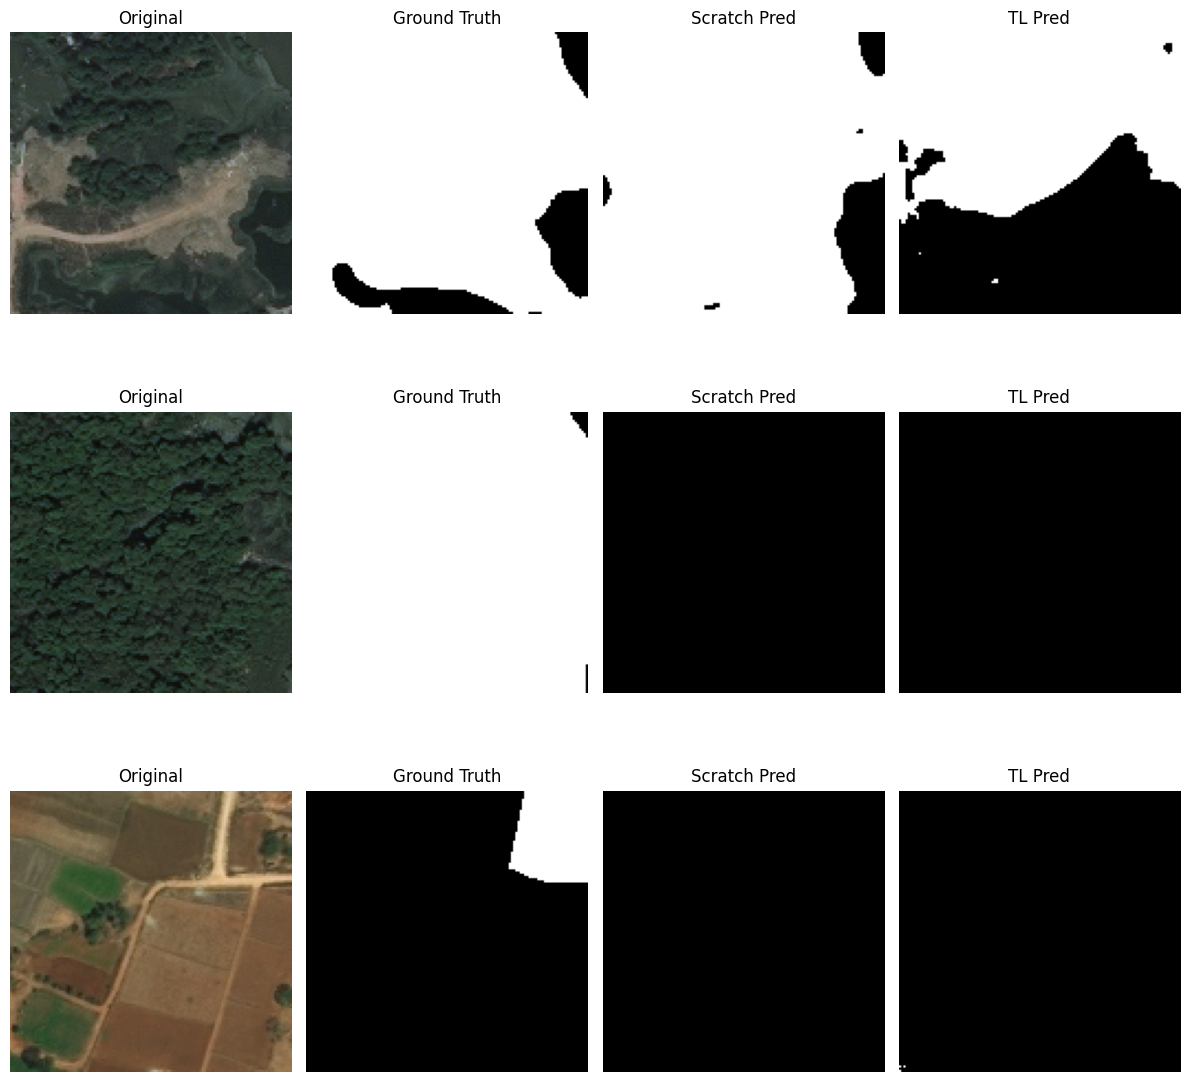

In [17]:
# Step 12: Show visual comparison
def visualize(model1, model2, dataset, n=3):
    model1.eval(); model2.eval()
    plt.figure(figsize=(12, 4*n))
    for i in range(n):
        img, mask = dataset[i]
        img_t = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred1 = torch.sigmoid(model1(img_t)).cpu().squeeze().numpy()
            pred2 = torch.sigmoid(model2(img_t)).cpu().squeeze().numpy()

        imgs = [
            img.permute(1,2,0).numpy(),
            mask.squeeze().numpy(),
            (pred1>0.5).astype(np.float32),
            (pred2>0.5).astype(np.float32)
        ]
        titles = ["Original", "Ground Truth", "Scratch Pred", "TL Pred"]
        for j, (im, t) in enumerate(zip(imgs, titles)):
            plt.subplot(n,4,i*4+j+1)
            plt.imshow(im, cmap='gray' if j>0 else None)
            plt.title(t)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize(scratch_model, tl_model, test_ds, n=3)

In [18]:
# Step 13: Comparative Analysis Template
analysis_text = f"""
# Comparative Analysis

## Performance
- Scratch IoU: {metrics_scratch['IoU']:.4f}
- Transfer Learning IoU: {metrics_tl['IoU']:.4f}
- Transfer Learning usually performs better because pre-trained ResNet50
  provides strong low-level feature extraction.

## Efficiency
- Training time Scratch: 65.15 minutes
- Training time Transfer Learning: {time_tl/60:.2f} minutes
- Transfer Learning converges faster and achieves higher IoU
  with less total effort during fine-tuning.

## Key Settings
- Image Size: 128×128
- Batch Size: 8
- Loss: BCE + Dice
- Optimizer: Adam
- Encoder: ResNet50 (pretrained on ImageNet)
"""
print(analysis_text)


# Comparative Analysis

## Performance
- Scratch IoU: 0.7197
- Transfer Learning IoU: 0.7455
- Transfer Learning usually performs better because pre-trained ResNet50
  provides strong low-level feature extraction.

## Efficiency
- Training time Scratch: 65.15 minutes
- Training time Transfer Learning: 50.68 minutes
- Transfer Learning converges faster and achieves higher IoU
  with less total effort during fine-tuning.

## Key Settings
- Image Size: 128×128
- Batch Size: 8
- Loss: BCE + Dice
- Optimizer: Adam
- Encoder: ResNet50 (pretrained on ImageNet)

